# T-distributed Stochastics Neighbor Embedding
## Motivation
### SNE
Let's talk about the origin of T-SNE, SNE, first. Suppose that we have a group of high dimensional data $x_1,...,x_n$, images for example. Since a data can be viewed as a point on a possible high-dimensional manifold, in this sense, if we want to reduce the dimension of data, then we must achieve:
- If $x_i$ and $x_j$ are "close" on a high-dimensional manifold, then their projection onto a low-dimensional space $z_i,z_j$ are close as well.

What SNE does is to minimize the KL divergence of high-dimensional data distribution and low-dimensional data distribution. Define
$$
P(x_j|x_i)=\frac{S(x_i,x_j)}{\sum_{k\neq i}S(x_i,x_k)}, \quad \text{for }1\leq i,j\leq n
$$
the conditional probability that $x_i$ would pick $x_j$ as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian centered at $x_i$ where under $P(x_j|x_i)$, the similarity $S(x_i,x_j)$ is defined as
$$
S(x_i,x_j)=\exp(-\|x_j-x_i\|/2\sigma_i^2),
$$
where $\sigma_i$ is the variance of the Gaussian that is centered on datapoint $x_i$. The similarity of $z_i,z_j$ is defined in the same fashion
$$
Q(x_j|x_i)=\frac{\exp(-\|z_j-z_i\|/2\sigma_i^2)}{\sum_{k\neq i}\exp(-\|z_k-z_i\|/2\sigma_i^2)}
$$
where the abused symbol $\sigma_i$ is the variance of the Gaussian that is centered on datapoint $z_i$. Since we are interested in pairwise similarities, we set $P(x_i|x_i)$ and $Q(z_i|z_i)$ to zero. 

If $z_i$ and $z_j$ correctly model the similarity of $x_i$ and $x_j$, the conditional probabilities $P(x_j|x_i)$ and $Q(z_j|z_i)$ will be equal. From this angle, we want to minimize the mismatch between $P(x_j|x_i)$ and $Q(z_j|z_i)$. A natural measure is the KL divergence 
$$
L=\sum_i KL(P(*|x_i)||Q(*|z_i))=\sum_j\sum_i P(x_j|x_i)\log\frac{P(x_j|x_i)}{Q(z_j|z_i)}
$$
to evaluate the performance of SNE.
### Symmetric SNE
Since the KL divergence is not symmetric, different types of error in the pairwise distances in the low-dimensional map are not weighted equally. Hence, we could consider the symmetric SNE that minimize the KL divergence of the **joint probability** of $P(x_i,x_j)$ and $Q(z_i,z_j)$
$$
L=KL(P||Q)=\sum_i\sum_j P(x_i,x_j)\log\frac{P(x_i,x_j)}{Q(z_i,z_j)}
$$
where 
$$
P(x_i,x_j)=\frac{\exp(-\|x_i-x_j\|^2/2\sigma^2)}{\sum_{k\neq \ell}\exp(-\|x_k-x_{\ell}\|^2/2\sigma^2)}
$$
and
$$
Q(z_i,z_j)=\frac{\exp(-\|z_i-z_j\|^2/2\sigma^2)}{\sum_{k\neq \ell}\exp(-\|z_k-z_{\ell}\|^2/2\sigma^2)}
$$
However, there's an underlying problem of this definition: if $x_i$ is an outlier, i.e. $\|x_j-x_i\|^2$ are large for all $j$, then $P(x_j|x_i)$ is small for all $j$. The location of low-dimensional map points do little effect on the loss function, and as a result, we cannot update low dimensional points $z_j$. A solution to this problem is to replace the conditional probabilit the joint probability $P(x_i,x_j)$ with the symmetrized conditional probabilities
$$
P_{new}(x_j|x_i)=\frac{P(x_j|x_i)+P(x_i|x_j)}{2n}
$$
so that $\sum_j P(x_i,x_j)>\frac{1}{2n}$ for all $i$, which every $x_i$ makes a significant contribution to the loss function. 
### Crowding Problem of SNE
Consider a unit square in ten-dimensional space and you want to embed it to $\mathbb{R}^2$. The distance of any two points of the unit square is always 1, but there are $2^{10}$ possibilities of these points. That is, the embedded square is "crowded" in $\mathbb{R}^2$. 

## T-SNE
To solve the crowding problem, we hope that the t-SNE repels dissimilar data and remains the relative distance in high-dimensional space in low-dimensional space. That is, we expect our embedding scheme satisfies
- If the distance of two points is short in high-dimensional space, then the embedded points are close.
- If the distance of two points is moderate in high-dimensional space, then the embedded points are farther.

The "t" in t-SNE means t-distribution with probability density function
$$
f(t) = \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu\pi}\Gamma(\frac{\nu}{2})}\left(1+\frac{t^2}{\nu}\right)^{-(\nu+1)/2}
$$
where $\nu$ is called the **degree of freedom**. If $\nu=1$, $f(t)$ becomes
$$
f(t)=\frac{1}{\pi(1+t^2)}
$$
with CDF
$$
\frac{1}{2}+\frac{1}{\pi}\arctan(t)
$$
which is the same as Cauchy distribution. T-SNE chooses t-distribution with one degree of freedom as the heavy-tailed distribution in the low-dimensional map, that is, the joint probability $Q(z_i,z_j)$ are defined as
$$
Q(z_i,z_j)=\frac{(1+\|z_j-z_i\|^2)^{-1}}{\sum_{k\neq i}(1+\|z_k-z_i\|^2)^{-1}}.
$$
The joint probability $P(x_i,x_j)$ and the loss are the same as of symmetric SNE. The gradient of the loss becomes
$$
\frac{\partial L}{\partial z_i}=4\sum_j(P(x_i,x_j)-Q(z_i,z_j))(1+\|z_i-z_j\|^2)^{-1}(z_i-z_j).
$$


## T-SNE visualization with MNIST

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
device = 'cpu'

In [5]:
config = {
    'n_epoch':10,
    'batch_size':64,
    'lr':0.001,
}

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])))

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # input size: (28,28,1)
        self.cnn = nn.Sequential(
            nn.Conv2d(1,6,5,1,2), 
            # padding: (32,32,1)
            # after Conv2d: (6,28,28)
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 
            # after pooling: (6,14,14)

            nn.Conv2d(6,16,5,1,0),
            # after Conv2d: (16,10,10)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0), 
            # after pooling: (16,5,5)
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(16*5*5,120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fully_connected(out)

In [8]:
model = Classifier()

In [9]:
from torchmetrics import Accuracy

def TrainCNN():
    # Pass model to gpu
    model.to(device)

    # Set to train mode
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 
    criterion = nn.CrossEntropyLoss()
    accuracy = Accuracy(task='multiclass',num_classes=10)

    accuracy = accuracy.to(device)

    for epoch in range(config['n_epoch']):
        train_loss, train_acc = 0.0, 0.0
        
        for batch in train_loader:
            # Seperate images and lables
            imgs, labels = batch

            # Forward the images
            # Make sure your images are passed to gpu
            pred = model(imgs.to(device))

            loss = criterion(pred, labels.to(device))
            train_loss += loss.item()

            acc = accuracy(pred, labels.to(device))
            train_acc += acc

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}")


In [10]:
TrainCNN()

Epoch: 0| Train loss:  0.12462| Train acc:  0.96198
Epoch: 1| Train loss:  0.05497| Train acc:  0.98348
Epoch: 2| Train loss:  0.03968| Train acc:  0.98800
Epoch: 3| Train loss:  0.03211| Train acc:  0.99050
Epoch: 4| Train loss:  0.02712| Train acc:  0.99213
Epoch: 5| Train loss:  0.02408| Train acc:  0.99335
Epoch: 6| Train loss:  0.02116| Train acc:  0.99402
Epoch: 7| Train loss:  0.01902| Train acc:  0.99422
Epoch: 8| Train loss:  0.01723| Train acc:  0.99460
Epoch: 9| Train loss:  0.01515| Train acc:  0.99595


In [11]:
checkpoint_path = 'model.pth'
torch.save(model.state_dict(), checkpoint_path)

In [12]:
del model
model = Classifier()
model.load_state_dict(torch.load('model.pth'))
model = model.to(device)

In [13]:
def generate_feature():
    model.eval()
    out_target = []
    out_data = []
    out_output =[]
    for data, target in train_loader:
        output = model(data)
        output_np = output.data.cpu().numpy()
        target_np = target.data.cpu().numpy()
        data_np = data.data.cpu().numpy()

        out_output.append(output_np)
        out_target.append(target_np[:, np.newaxis])
        out_data.append(np.squeeze(data_np))

    output_array = np.concatenate(out_output, axis=0)
    target_array = np.concatenate(out_target, axis=0)
    data_array = np.concatenate(out_data, axis=0)

    np.save(os.path.join('output', 'output.npy'), output_array, allow_pickle=False)
    np.save(os.path.join('output', 'target.npy'), target_array, allow_pickle=False)
    np.save(os.path.join('output', 'data.npy'), data_array, allow_pickle=False)

In [14]:
generate_feature()

In [15]:
output = np.load('output/output.npy').astype(np.float64)
target = np.load('output/target.npy')
print('target shape: ', target.shape)
print('output shape: ', output.shape)

target shape:  (60000, 1)
output shape:  (60000, 10)


In [17]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
data = output[:25000,:]
plotlabel = target[:25000]

plotdata = tsne.fit_transform(data)

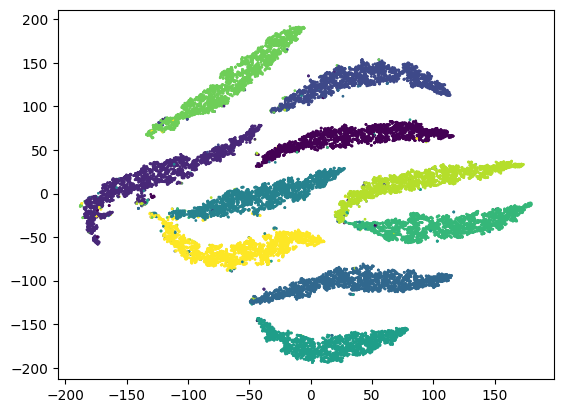

In [20]:
plt.scatter(plotdata[:, 0], plotdata[:, 1], s=1, c=plotlabel)

# References
- https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf?fbcl
- https://github.com/oreillymedia/t-SNE-tutorial